In [ ]:
!pip3 install preprocess-kgptalkie


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/twitter_sentiment.csv', header=None, index_col=[0])
df = df[[2,3]].reset_index(drop=True)
df.columns = ['sentiment', 'text']
df.head(20)

,sentiment,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...
5,Positive,im getting into borderlands and i can murder y...
6,Positive,So I spent a few hours making something for fu...
7,Positive,So I spent a couple of hours doing something f...
8,Positive,So I spent a few hours doing something for fun...
9,Positive,So I spent a few hours making something for fu...


In [ ]:
df.info()

df.isnull().sum()

df.dropna(inplace=True)

df = df[df['text'].apply(len)>1]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75682 entries, 0 to 75681
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  75682 non-null  object
 1   text       74996 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [ ]:
df['sentiment'].value_counts()
!pip install googletrans==4.0.0rc1


In [ ]:
import preprocess_kgptalkie as ps

# Create a new DataFrame with the extracted features
features_df = df['text'].apply(ps.extract_features).apply(pd.Series)

# Concatenate the new features with the original DataFrame
df = pd.concat([df, features_df], axis=1)

In [ ]:
# prompt: replace each word 'kill' in the data by 'male' and inplace = true

df['text'] = df['text'].str.replace('kill', 'male', regex=False)
df['text'] = df['text'].str.replace('murder', 'happy', regex=False)
df['text'] = df['text'].str.replace('please', 'hard', regex=False)
df['text'] = df['text'].str.replace('noticed', 'kill', regex=False)
df['text'] = df['text'].str.replace('biggest', 'murder', regex=False)


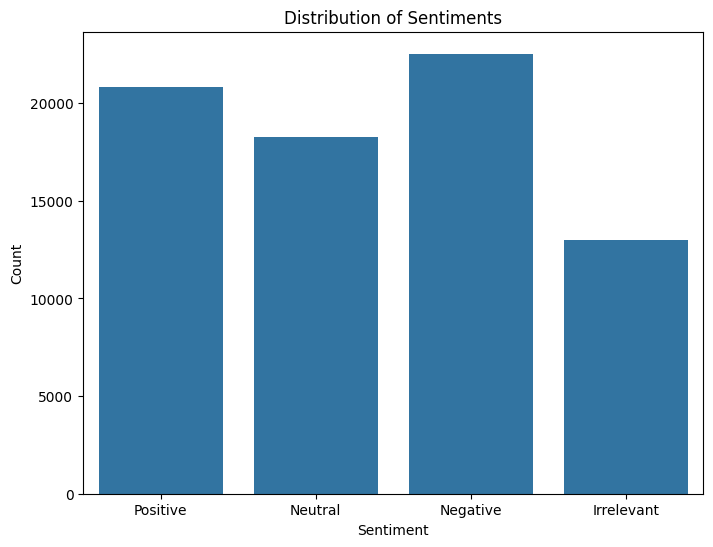

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'sentiment' is the column containing sentiment labels
sentiment_counts = df['sentiment'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

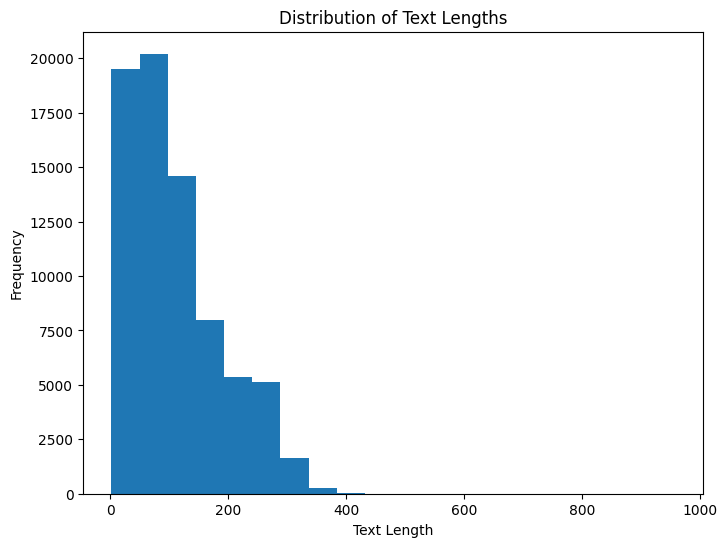

In [ ]:
# Assuming 'text' is the column containing text data
text_lengths = df['text'].apply(len)

# Create a histogram
plt.figure(figsize=(8, 6))
plt.hist(text_lengths, bins=20)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

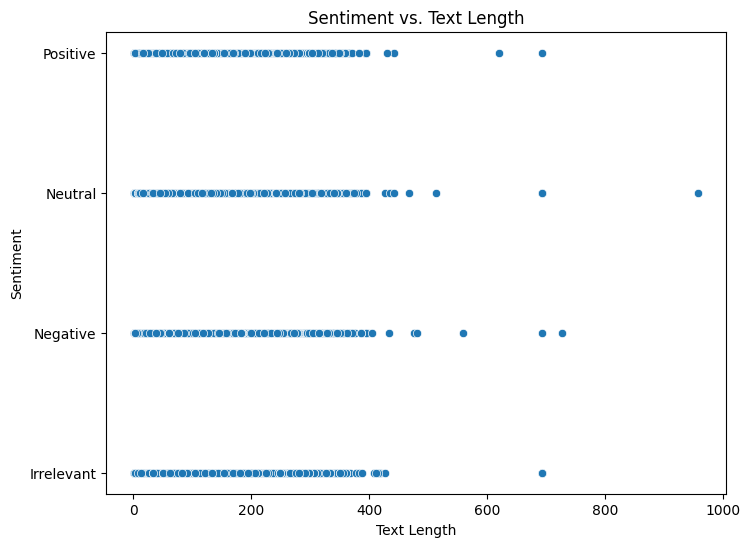

In [ ]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=text_lengths, y='sentiment', data=df)
plt.title('Sentiment vs. Text Length')
plt.xlabel('Text Length')
plt.ylabel('Sentiment')
plt.show()

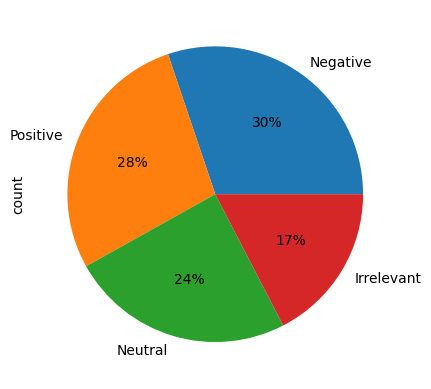

In [ ]:
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.0f%%')

# word cloud
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

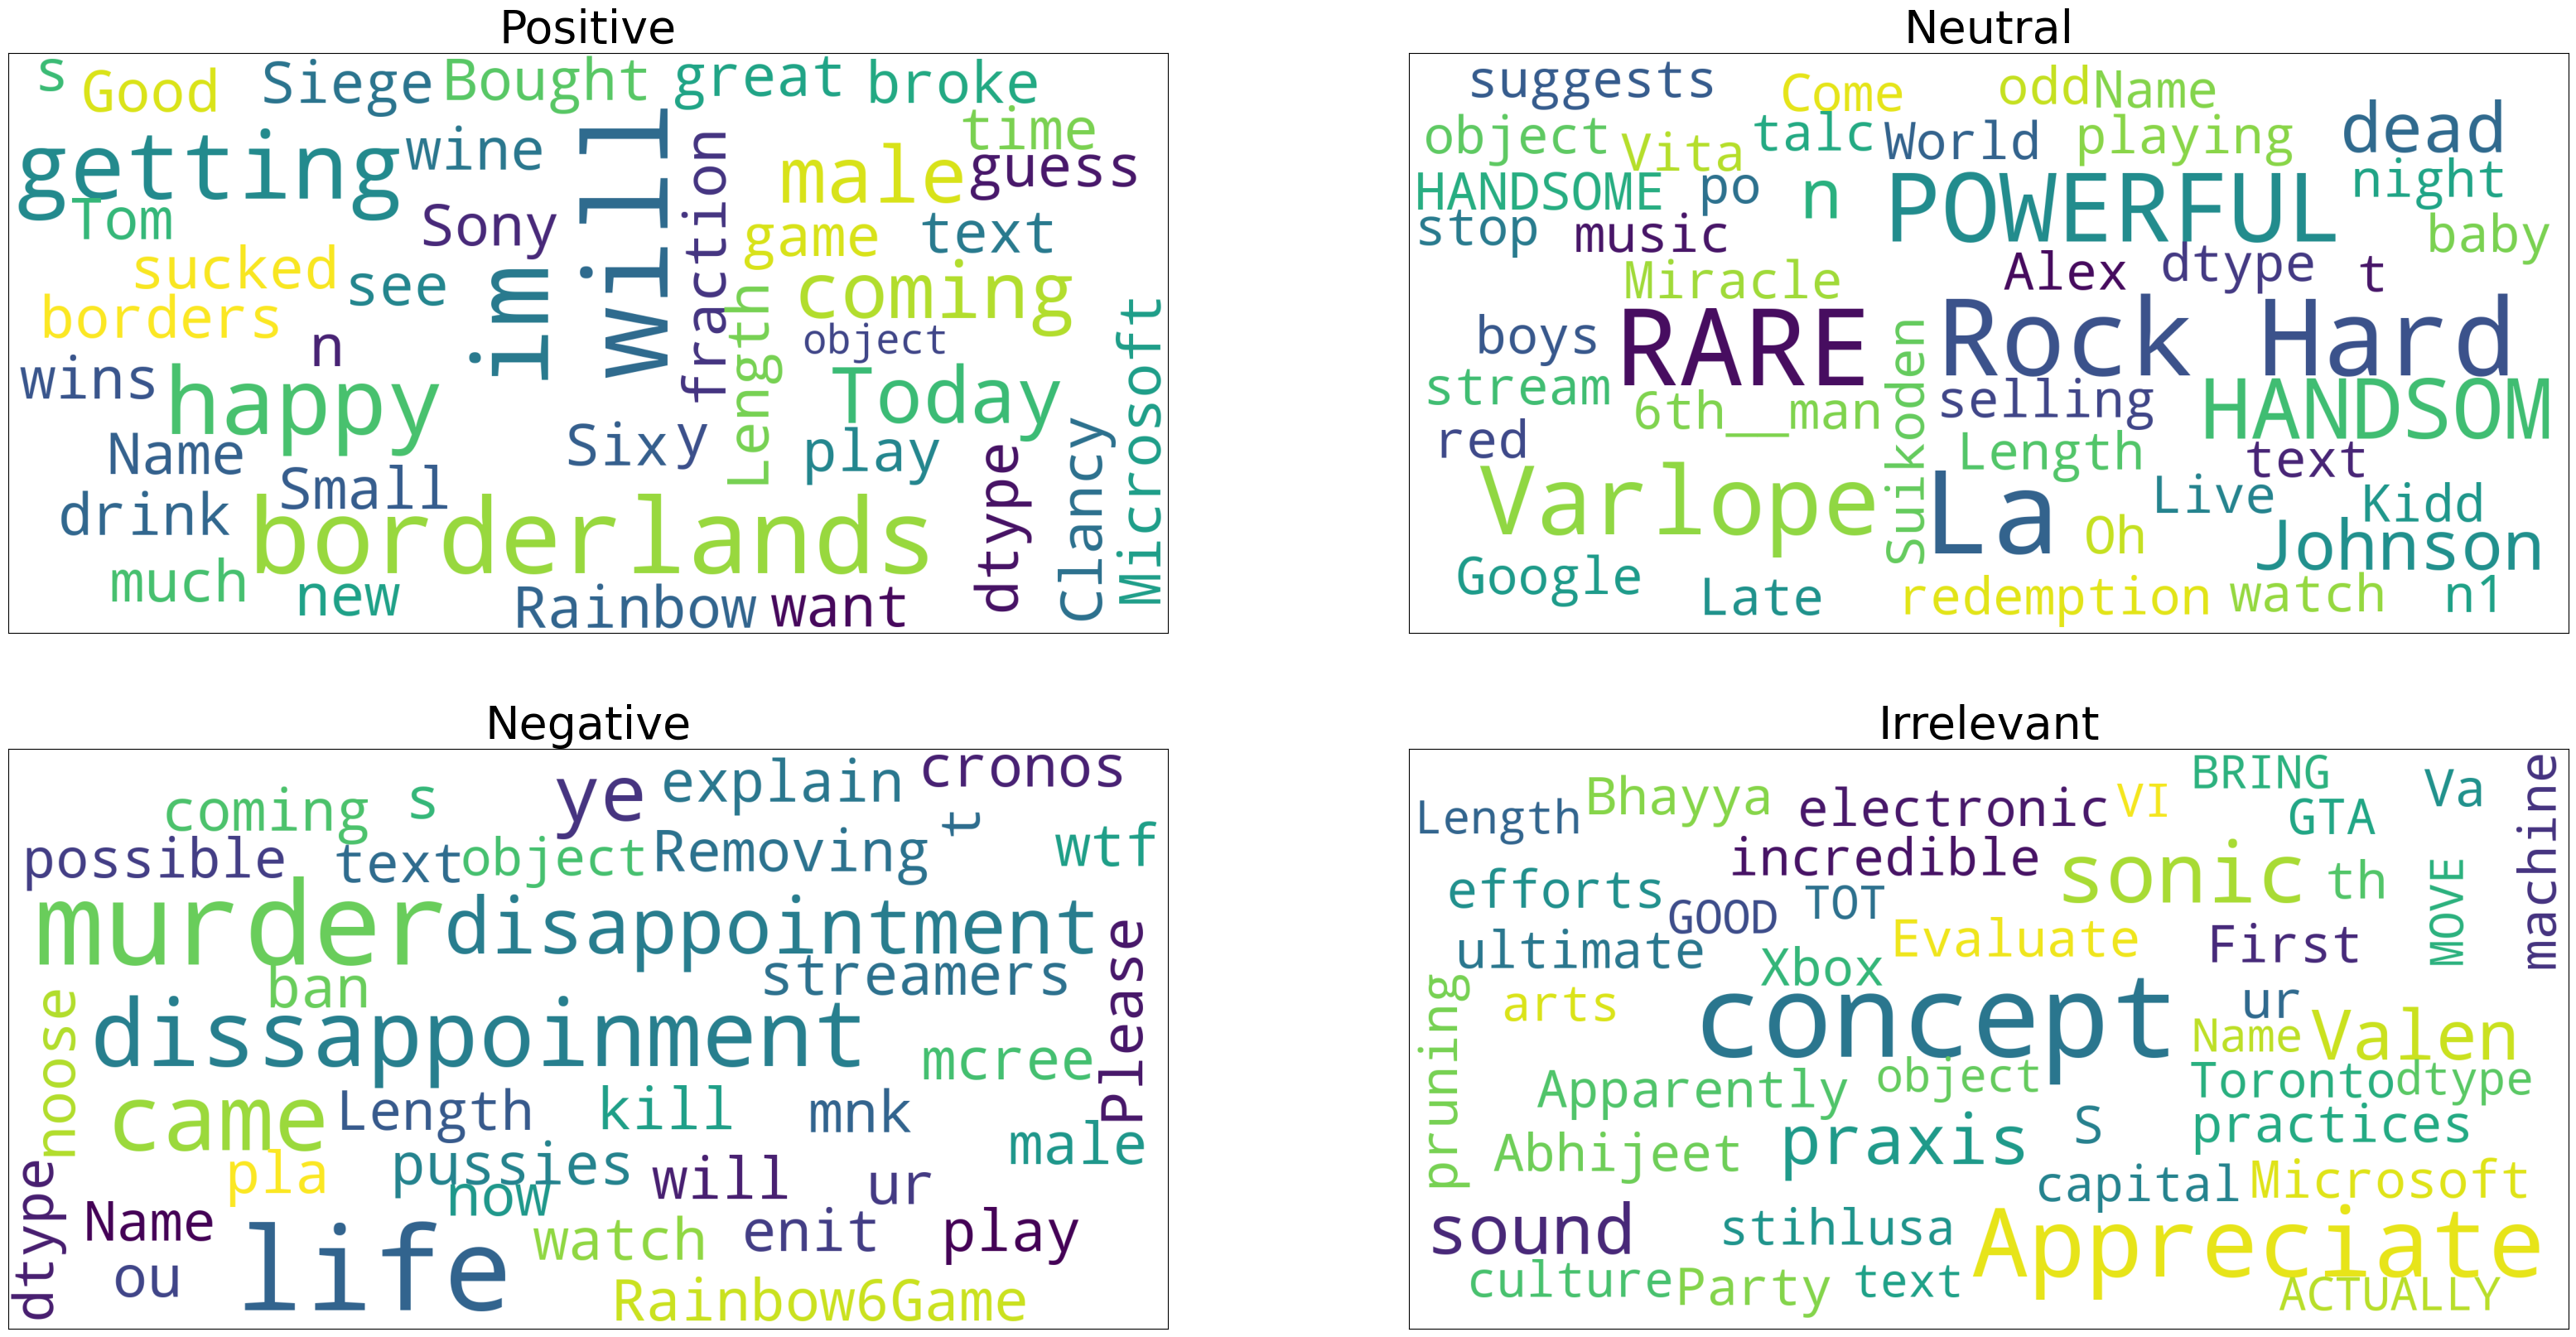

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot 2x2 grid word cloud for each sentiment
plt.figure(figsize=(40,20))

for index, col in enumerate(df['sentiment'].unique()):
    plt.subplot(2,2, index+1)
    # print(col)
    df1 = df[df['sentiment']==col]
    data = df1['text']
    wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=500, max_font_size=40, scale=5).generate(str(data))
    # fig = plt.figure(figsize=(15,15))
    # plt.axis('off')
    # disable ticks
    plt.xticks([])
    plt.yticks([])
    plt.imshow(wordcloud)
    plt.title(col, fontsize=40)

plt.show()
plt.tight_layout()

In [ ]:
# Data Cleaning
# lowercase, remove url, html, punctuations, retweet

df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply(lambda x: ps.remove_urls(x))
df['text'] = df['text'].apply(lambda x: ps.remove_html_tags(x))
df['text'] = df['text'].apply(lambda x: ps.remove_special_chars(x))
df['text'] = df['text'].apply(lambda x: ps.remove_rt(x))

In [ ]:
# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)

In [ ]:
X_train.shape, X_test.shape


((59717,), (14930,))

In [ ]:
# model building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Convert the stopwords set to a list
stop_words_list = list(stopwords)

clf = Pipeline([('tfidf', TfidfVectorizer(stop_words=stop_words_list)), ('clf', RandomForestClassifier(n_estimators=150, n_jobs=-1))])
clf.fit(X_train, y_train)

# evaluation
from sklearn.metrics import accuracy_score

predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))



0.9126590756865371


In [ ]:
# prompt: save the model using pickle

import pickle

# Save the model to a file
pickle.dump(clf, open('model.pkl', 'wb'))

In [ ]:
clf.predict(['iam really appy to see you in the movie'])

array(['Positive'], dtype=object)

In [ ]:
pickle = pickle.load(open('model.pkl', 'rb'))
pickle.predict(['iam really appy to see you in the movie'])

array(['Positive'], dtype=object)

In [ ]:
!pip install streamlit==1.28.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1
  Attempting uninstall: importlib-metadata
    Found

In [ ]:
%%writefile app.py
import streamlit as st
import pickle

# Load the model
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

# Create the Streamlit app
st.title('Sentiment Prediction App')
user_input = st.text_input('Enter some text:')

if user_input:
    prediction = model.predict([user_input])
    st.write(f'Prediction: {prediction[0]}')

Writing app.py


In [ ]:
! wget -q -O - ipv4.icanhazip.com


34.125.151.164


In [ ]:
!pip install localtunnel@2.0.2


ERROR: Could not install packages due to an OSError: Invalid URL '2.0.2': No scheme supplied. Perhaps you meant https://2.0.2?



In [ ]:
!npm install -g localtunnel


added 22 packages, and audited 23 packages in 4s

3 packages are looking for funding
  run `npm fund` for details

1 moderate severity vulnerability

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501




your url is: https://seven-shoes-wish.loca.lt

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.151.164:8501

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(
  Stopping...
^C
